In [1]:
# The convolutional neural network in this document has been inspired by Mikkel N. Schmidt's example.

In [1]:
#%% Import libraries
import numpy as np
import pandas as pd
from numpy import genfromtxt
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pylab as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

# Load training and test dataframes & TF-IDF matrices

In [2]:
# Load sentences and labels
train = pd.read_csv(r'train_dataframe.csv')
test = pd.read_csv(r'test_dataframe.csv')

In [3]:
train_labels = train["Labels"].tolist()
test_labels = test["Labels"].tolist()

In [4]:
train_tf_idf = pd.read_csv(r'DTTFIDFM_train.csv')
test_tf_idf = pd.read_csv(r'DTTFIDFM_test.csv')

train_tf_idf = train_tf_idf.drop('Unnamed: 0', axis=1)
test_tf_idf = test_tf_idf.drop('Unnamed: 0', axis=1)

In [5]:
train_tf_idf_numpy = train_tf_idf.to_numpy()
test_tf_idf_numpy = test_tf_idf.to_numpy()

# CNN

## Load SVD-matrix:

In [8]:
# Load SVD-matrix from csv-file
V_500 = genfromtxt('V500.csv', delimiter=',')

## Sentence LSA embedding

In [9]:
def sentence_LSA_embedding(TF_IDF_matrix_numpy, V_k):
    liste_LSA_vektorer = []
    for i in range(TF_IDF_matrix_numpy.shape[0]):
        lsa_vector = np.dot(TF_IDF_matrix_numpy[i], V_k)
        liste_LSA_vektorer.append(lsa_vector)
    return np.array(liste_LSA_vektorer)

In [10]:
train_lsa = sentence_LSA_embedding(train_tf_idf_numpy, V_500)
test_lsa = sentence_LSA_embedding(test_tf_idf_numpy, V_500)

## Make tensors

In [56]:
# Convert inputs
train_input_tensor = torch.tensor(train_lsa, dtype=torch.float32)  # Shape: (num_train_sentences, 200)
test_input_tensor = torch.tensor(test_lsa, dtype=torch.float32)    # Shape: (num_test_sentences, 200)

# Convert labels
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)  # Shape: (num_train_sentences,)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)    # Shape: (num_test_sentences,)

In [57]:
# Reshape the tensors for CNN input (adding the channel dimension)
train_input_tensor = train_input_tensor.unsqueeze(1)  # Shape: (num_train_sentences, 1, 200)
test_input_tensor = test_input_tensor.unsqueeze(1)    # Shape: (num_test_sentences, 1, 200)

In [59]:
batch_size = 64
# Create datasets
train_dataset = TensorDataset(train_input_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_input_tensor, test_labels_tensor)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Shuffle training data
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)   # No shuffle for testing

## Build the CNN

In [69]:
num_epochs = 33
learning_rate = 0.0006
weight_decay = 0.0001

In [70]:
#%% Device
# Run on GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"

In [71]:
#%% Neural network
net = torch.nn.Sequential(
    # Convolutional layer
    torch.nn.Conv1d(1, 16, kernel_size=3), # 500 - 3 + 1 = 498
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.3),
    torch.nn.MaxPool1d(kernel_size=2), # 498 // 2 = 249

    torch.nn.Flatten(), # 128, 16*249 = 3984

    # First linear
    torch.nn.Linear(3984, 1992), # 128, 1992
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.3),

    # Second linear
    torch.nn.Linear(1992, 996), # 996
    torch.nn.ReLU(),

    # Third layer
    torch.nn.Linear(996, 498), # 498
    torch.nn.ReLU(),
    torch.nn.Linear(498, 2) # 249

    ).to(device)

In [73]:
unique, counts = np.unique(train_labels, return_counts=True)
print(dict(zip(unique, counts)))

{0: 2454, 1: 2475}


In [74]:
#%% Loss and optimizer
class_weights = torch.tensor([1., 1.]).to(device)
loss_function = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [89]:
# %% Load trained network from file
net.load_state_dict(torch.load('netV2.pt'))

C:\Users\chris\AppData\Local\Temp\ipykernel_16300\3527773167.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('netV2.pt'))


<All keys matched successfully>

## Train

In [86]:
#%% Train
train_loss = {}
test_loss = {}
train_accuracy = {}
test_accuracy = {}
step = 0

test_labels_dronning = {}
test_labels_statsminister = {}

scheduler = CosineAnnealingLR(optimizer, T_max=50)

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        net.train()

        # Put data on GPU 
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Compute loss and take gradient step
        outputs = net(inputs)
        loss = loss_function(outputs, labels)

        loss.backward()
        optimizer.step()

        predicted = torch.argmax(outputs, dim=1)

        running_loss += loss.item()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Print accuracy for epoch            
    epoch_loss = running_loss / len(train_loader)

    train_loss[epoch] = epoch_loss

    epoch_accuracy = 100 * correct / total

    train_accuracy[epoch] = epoch_accuracy

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training loss: {epoch_loss:.4f}, Training accuracy: {epoch_accuracy:.2f}%")

    # Evaluate the model
    net.eval()
    correct = 0
    total = 0
    running_loss_test = 0.0

    dronning_correct = 0
    dronning_total = 0
    statsminister_correct = 0
    statsminister_total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            # Put data on GPU 
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = net(inputs).float()
            
            predicted = torch.argmax(outputs, dim=1)

            loss = loss_function(outputs, labels)
            
            running_loss_test += loss.item()

            # Count correct predictions
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Label-wise counting
            dronning_correct += (((predicted == 0) & (labels == 0))).sum().item()
            dronning_total += (labels == 0).sum().item()

            statsminister_correct += (((predicted == 1) & (labels == 1))).sum().item()
            statsminister_total += (labels == 1).sum().item()

        epoch_loss_test = running_loss_test / len(test_loader)
        test_loss[epoch] = epoch_loss_test

    test_accuracy_score = 100 * correct / total
    
    dronning_acc = 100.0 * dronning_correct / dronning_total
    statsminister_acc = 100.0 * statsminister_correct / statsminister_total

    # Store label-wise accuracy for testing
    test_labels_dronning[epoch] = dronning_acc
    test_labels_statsminister[epoch] = statsminister_acc

    test_accuracy[epoch] = test_accuracy_score

    print(f"Test loss: {epoch_loss:.4f}, Test accuracy: {test_accuracy_score:.2f}%")
    print(f"Dronning (0) accuracy: {dronning_acc:.2f}% - Statsminister (1) accuracy: {statsminister_acc:.2f}%")
    print()

    scheduler.step()

Epoch 1/33
Training loss: 0.3346, Training accuracy: 85.96%
Test loss: 0.3346, Test accuracy: 72.43%
Dronning (0) accuracy: 73.56% - Statsminister (1) accuracy: 71.27%

Epoch 2/33
Training loss: 0.3129, Training accuracy: 86.57%
Test loss: 0.3129, Test accuracy: 71.76%
Dronning (0) accuracy: 76.20% - Statsminister (1) accuracy: 67.20%

Epoch 3/33
Training loss: 0.3140, Training accuracy: 86.41%
Test loss: 0.3140, Test accuracy: 71.82%
Dronning (0) accuracy: 75.12% - Statsminister (1) accuracy: 68.43%

Epoch 4/33
Training loss: 0.3063, Training accuracy: 86.45%
Test loss: 0.3063, Test accuracy: 71.70%
Dronning (0) accuracy: 74.28% - Statsminister (1) accuracy: 69.05%

Epoch 5/33
Training loss: 0.3015, Training accuracy: 86.57%
Test loss: 0.3015, Test accuracy: 71.27%
Dronning (0) accuracy: 74.04% - Statsminister (1) accuracy: 68.43%

Epoch 6/33
Training loss: 0.3018, Training accuracy: 86.67%
Test loss: 0.3018, Test accuracy: 71.70%
Dronning (0) accuracy: 76.20% - Statsminister (1) accu

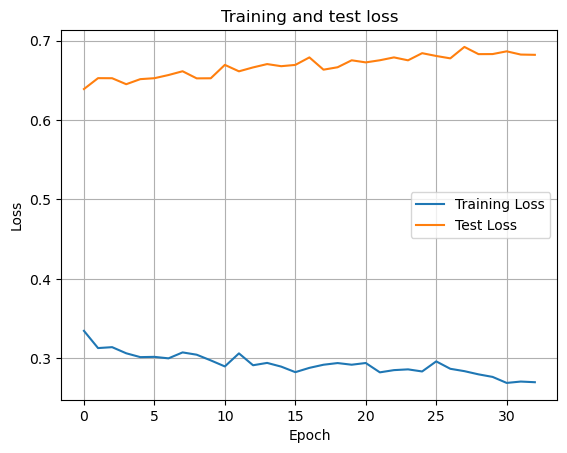

In [90]:
plt.plot(train_loss.values(), label="Training Loss")
plt.plot(test_loss.values(), label="Test Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and test loss")
plt.grid(True)

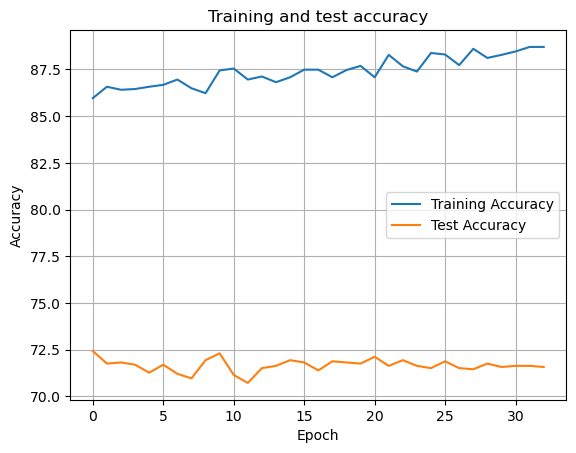

In [91]:
plt.plot(train_accuracy.values(), label="Training Accuracy")
plt.plot(test_accuracy.values(), label="Test Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and test accuracy")
plt.grid(True)

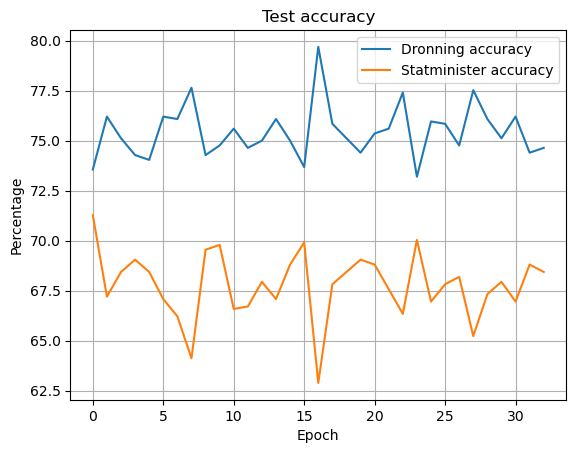

In [92]:
plt.plot(test_labels_dronning.values(), label="Dronning accuracy")
plt.plot(test_labels_statsminister.values(), label="Statminister accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Percentage")
plt.title("Test accuracy")
plt.grid(True)

In [80]:
# %% Save the trained model
torch.save(net.state_dict(), 'netV2.pt')